# Installations

In [34]:
!pip install xarray
!pip install netcdf4
!pip install azure-storage-file-share
!pip install dask-ml[complete] 
!pip install dask

# Imports

In [1]:
import os
%matplotlib inline
import matplotlib.pyplot as plt

# data management
import xarray as xr
import numpy as np
import pandas as pd

# Azure
import azureml.core
from azureml.core import Workspace
from azure.storage.fileshare import ShareFileClient

#dask
import dask

# utilities
import time

### Verify that the files are now available locally

In [2]:
!ls

Explore_nc_file_01.ipynb
Seattle_Region_Avg-copy.ipynb
Seattle_Region_Avg.ipynb
explore_nc_file_01.ipynb.amltmp
seattle_region_avg-copy.ipynb.amltmp
seattle_region_avg.ipynb.amltmp
tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2006.nc
tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2007.nc
tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2008.nc
tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2030.nc
tasmin_day_BCSD_rcp85_r1i1p1_inmcm4_2006.nc
tasmin_day_BCSD_rcp85_r1i1p1_inmcm4_2007.nc
tasmin_day_BCSD_rcp85_r1i1p1_inmcm4_2008.nc


## Understand grids, applicability to our area of interest

In [3]:
ds = xr.open_dataset("tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2006.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 720, lon: 1440, time: 365)
Coordinates:
  * time     (time) object 2006-01-01 12:00:00 ... 2006-12-31 12:00:00
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
Data variables:
    tasmax   (time, lat, lon) float32 ...
Attributes:
    parent_experiment:              historical
    parent_experiment_id:           historical
    parent_experiment_rip:          r1i1p1
    Conventions:                    CF-1.4
    institution:                    NASA Earth Exchange, NASA Ames Research C...
    institute_id:                   NASA-Ames
    realm:                          atmos
    modeling_realm:                 atmos
    version:                        1.0
    downscalingModel:               BCSD
    experiment_id:                  rcp85
    frequency:                      day
    realization:                    1
    initialization_method:          1
    physics_version:                1
    tracking_id:                    21e94b3e-5668-431d-8173-7eb278d77545
    driving_data_tracking_ids:      N/A
    driving_model_ensemble_member:  r1i1p1
    driving_experiment_name:        historical
    driving_experiment:             historical
    model_id:                       BCSD
    references:                     BCSD method: Thrasher et al., 2012, Hydro...
    DOI:                            http://dx.doi.org/10.7292/W0MW2F2G
    experiment:                     RCP8.5
    title:                          INMCM4 global downscaled NEX CMIP5 Climat...
    contact:                        Dr. Rama Nemani: rama.nemani@nasa.gov, Dr...
    disclaimer:                     This data is considered provisional and s...
    resolution_id:                  0.25 degree
    project_id:                     NEXGDDP
    table_id:                       Table day (12 November 2010)
    source:                         BCSD 2014
    creation_date:                  2015-01-07T20:32:58Z
    forcing:                        N/A
    product:                        output

#### 0.25 degree grid
There are 180 x 4 = 720 latitudes, and  
there are 360 x 4 = 1440 longitudes  
So, as expected, data is available in 0.25 degree grid

#### Time = 365
So, one record for each day of the year

### Let us see a few entries of latitudes
Of the 720 elements in latitudes, let us look at middle values like 360, 361, ...

In [4]:
# Of the 720 elements in latitudes, let us look at middle values like 360, 361, ...
ds[dict(lat=[360, 361, 362, 363],lon=0,time=0)]

<xarray.Dataset>
Dimensions:  (lat: 4)
Coordinates:
    time     object 2006-01-01 12:00:00
  * lat      (lat) float32 0.125 0.375 0.625 0.875
    lon      float32 0.125
Data variables:
    tasmax   (lat) float32 ...
Attributes:
    parent_experiment:              historical
    parent_experiment_id:           historical
    parent_experiment_rip:          r1i1p1
    Conventions:                    CF-1.4
    institution:                    NASA Earth Exchange, NASA Ames Research C...
    institute_id:                   NASA-Ames
    realm:                          atmos
    modeling_realm:                 atmos
    version:                        1.0
    downscalingModel:               BCSD
    experiment_id:                  rcp85
    frequency:                      day
    realization:                    1
    initialization_method:          1
    physics_version:                1
    tracking_id:                    21e94b3e-5668-431d-8173-7eb278d77545
    driving_data_tracking_ids:      N/A
    driving_model_ensemble_member:  r1i1p1
    driving_experiment_name:        historical
    driving_experiment:             historical
    model_id:                       BCSD
    references:                     BCSD method: Thrasher et al., 2012, Hydro...
    DOI:                            http://dx.doi.org/10.7292/W0MW2F2G
    experiment:                     RCP8.5
    title:                          INMCM4 global downscaled NEX CMIP5 Climat...
    contact:                        Dr. Rama Nemani: rama.nemani@nasa.gov, Dr...
    disclaimer:                     This data is considered provisional and s...
    resolution_id:                  0.25 degree
    project_id:                     NEXGDDP
    table_id:                       Table day (12 November 2010)
    source:                         BCSD 2014
    creation_date:                  2015-01-07T20:32:58Z
    forcing:                        N/A
    product:                        output

#### Those latitude values are 0.125, 0.375, 0.625, 0.875

Seemingly representing mid points from 0-0.25, 0.25-0.5, 0.5-0.75, 0.75-1.00

#### Area of Interest (Seattle region)
As determined separately, the chosen Area of Interest for Seattle region is:  
* Latitudes 47.25 to 48.12, and
* Longitudes -122.32 to -121.56

However, we have longitude values from 0 to 360, instead of -180 to 180.  
So, we convert as follows:

In [5]:
print('-121.56 = ', -121.56 % 360)
print('-122.32 = ', -122.32 % 360)

-121.56 =  238.44
-122.32 =  237.68


### Updated Area of Interest (Seattle region)
So, the updated Area of Interest for Seattle region is:  
* Latitudes 47.25 to 48.12, and
* Longitudes 237.68 to 238.44

### Mapping to Grid (weighted)
#### Latitudes
Latitudes range 47.25 to 48.12 spans over the grids as follows:  
* 47.25 to 47.50 (represented by 47.38, fully)
* 47.50 to 47.75 (represented by 47.62, fully)
* 47.75 to 48.00 (represented by 47.88, fully)
* 48.00 to 48.25 (represented by 48.12, partially 12/25 = 0.48)

#### Longitudes
Longitudes range 237.68 to 238.44 spans over the grids as follows:  
* 237.50 to 237.75 (represented by 237.6, partially 12/25 = 0.48)
* 237.75 to 238.00 (represented by 237.9, fully)
* 238.00 to 238.25 (represented by 238.1, fully)
* 238.25 to 238.50 (represented by 238.4, partially 19/25 = 0.76)

### Matching index values of Grid
#### Latitudes
There are 4 parts in each degree, therefore 47.38 should be:  
element number (137*4) + 2 = 550  
which is index number 549.
Four elements in all, so index range **549 to 552**.

#### Longitudes
There are 4 parts in each degree, therefore 237.62 should be:  
element number (237*4) + 3 = 951  
which is index number 950.
Four elements in all, so index range **950 to 953**.

#### Let us verify these index range values...

In [6]:
# Indices for the representative Grids
lat_indices=[549, 550, 551, 552]
lon_indices=[950, 951, 952, 953]
ds[dict(lat=lat_indices,lon=lon_indices,time=0)]

<xarray.Dataset>
Dimensions:  (lat: 4, lon: 4)
Coordinates:
    time     object 2006-01-01 12:00:00
  * lat      (lat) float32 47.38 47.62 47.88 48.12
  * lon      (lon) float32 237.6 237.9 238.1 238.4
Data variables:
    tasmax   (lat, lon) float32 ...
Attributes:
    parent_experiment:              historical
    parent_experiment_id:           historical
    parent_experiment_rip:          r1i1p1
    Conventions:                    CF-1.4
    institution:                    NASA Earth Exchange, NASA Ames Research C...
    institute_id:                   NASA-Ames
    realm:                          atmos
    modeling_realm:                 atmos
    version:                        1.0
    downscalingModel:               BCSD
    experiment_id:                  rcp85
    frequency:                      day
    realization:                    1
    initialization_method:          1
    physics_version:                1
    tracking_id:                    21e94b3e-5668-431d-8173-7eb278d77545
    driving_data_tracking_ids:      N/A
    driving_model_ensemble_member:  r1i1p1
    driving_experiment_name:        historical
    driving_experiment:             historical
    model_id:                       BCSD
    references:                     BCSD method: Thrasher et al., 2012, Hydro...
    DOI:                            http://dx.doi.org/10.7292/W0MW2F2G
    experiment:                     RCP8.5
    title:                          INMCM4 global downscaled NEX CMIP5 Climat...
    contact:                        Dr. Rama Nemani: rama.nemani@nasa.gov, Dr...
    disclaimer:                     This data is considered provisional and s...
    resolution_id:                  0.25 degree
    project_id:                     NEXGDDP
    table_id:                       Table day (12 November 2010)
    source:                         BCSD 2014
    creation_date:                  2015-01-07T20:32:58Z
    forcing:                        N/A
    product:                        output

### Checks out!
We are getting the desired grid cells with the noted indices for latitude and longitude.  

Let us also define, in code, the weights.

In [7]:
# based on grid cell starting degree
grid_lat_weight = [1, 1, 1, 0.48]
grid_lon_weight = [0.48, 1, 1, 0.76]

# Generate Average: Implementation 1 - One file at a time.

### First, the custom functions that implement the logic

In [8]:
def CreateDatasetForAverageRecord():
    """
    A function that creates an empty dataframe for use in Logic that populates value in such a record.
    The standard format for this 'record' dataframe will have: 
        365 rows for each day of the year and, 
        will have the following columns:
        - Max_Years : reduntanct column storing the number of years of data for max temperature
        - Min_Years : reduntanct column storing the number of years of data for min temperature
        - Peak_Maximum    : Maxium value across all years
        - Peak_Minimum    : Minium value across all years
        - Avg_Maximum     : Average maximum from all years
        - Avg_Minimum     : Average minimum from all years
        
    Returns: a pandas dataset
    """
    col_names = ['Max_Years', 'Min_Years','Peak_Maximum','Peak_Minimum','Avg_Maximum','Avg_Minimum']
    ds_rec = pd.DataFrame(columns=col_names, index=range(0,365))
    return ds_rec


def CreateGridWeights(lat_weights, lon_weights):
    """
    A function that creates an numpy matrix of grid weights.
    Calculated from the weights along the latitudes and those along the longitudes
    Input Parameters:
    - lat_weights  : Applicable weights along latitudes
    - lon_weights  : Applicable weights along latitudes
        
    Returns: A numpy matrix of grid weights
    """
    # first broadcast list to matrix
    grid_lat_weights = np.reshape(lat_weights*4, (4,4))
    grid_lon_weights = np.reshape(lon_weights*4, (4,4))
    grid_weights = np.multiply(np.transpose(grid_lat_weights), grid_lon_weights)
    return grid_weights


def GenerateAverageOneFileAtATime(record, lat_indices, lon_indices, grid_weights
    , filename, filetype='max'):
    """
    Takes one file at a time and updates the average, peak values in the existing 'record' dataframe.
    This function will take longer to get through all the files, but will take much lesser memory...
    ...as compared to other implementation which will load multiple files simultaneously.
    Input Parameters:
    - record      : pandas dataframe with avg_max, avg_min, peak_max, peak_min for 365 days
    - lat_indices : applicable index values for latitudes
    - lon_indices : applicable index values for longitudes
    - grid_weights : applicable weights matrix based on grid-mapping to the Area of Interest
    - filename    : name of the .nc file to process
    - type of file: string 'max' or 'min'
    Returns:  None. The input pandas dataframe 'record' is updated.
    """
    # load the file
    xds = xr.open_dataset(filename)
    
    # take applicabel subset of lat and lon
    xds = xds[dict(lat=lat_indices,lon=lon_indices)]
    
    # print("xds", xds)     ## For debugging
    # print(grid_weights)   ## For debugging

    # max or min
    idx_year = 0        # default: max 
    idx_peak = 2        # default: max
    idx_minmax = 4      # default: max
    var_minmax = 'tasmax'
    if filetype == "min":
        idx_year = 1
        idx_peak = 3
        idx_minmax = 5
        var_minmax = 'tasmin'

    new_values = np.round(np.multiply(xds[var_minmax][:], grid_weights).sum(axis=2).sum(axis=1)/np.sum(grid_weights), 2)
    new_values = ((new_values - 273.15)*(9/5)) + 32

    n_years = 1
    # If not first year 
    if not pd.isnull(record.iloc[0,idx_year]):                
        n_years = record.iloc[0,idx_year] + 1     # number of years

    # if first time for this type of file (min or max)
    if pd.isnull(record.iloc[0,idx_peak]):
        record.iloc[:, idx_peak] = new_values       # peak temperature
        record.iloc[:, idx_minmax] = new_values     # avg temperature
    else:
        if filetype == "min":        
            record.iloc[:, idx_peak] = xr.ufuncs.minimum(new_values, record.iloc[:, idx_peak])   # peak min temperature across years
        else:
            record.iloc[:, idx_peak] = xr.ufuncs.maximum(new_values, record.iloc[:, idx_peak])   # peak max temperature across years
        
        record.iloc[:, idx_minmax] = np.round(((record.iloc[:, idx_minmax] * (n_years-1)) + new_values)/n_years, 2)  # avg across years
    
    # in any case...
    record.iloc[:,idx_year] = n_years                  # number of years
        


### Now call the functions to implement the logic of generating average temperature processing one file at a time

In [9]:
ds_record = CreateDatasetForAverageRecord()  # creates the standard format dataframe for our purpose

# prepare the name of files to process
max_files = ['tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2006.nc'
            ,'tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2007.nc'
            , 'tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2008.nc']

# max_files = ['tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2006.nc'
#             , 'tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2008.nc']

# max_files = ['tasmax_day_BCSD_rcp85_r1i1p1_inmcm4_2006.nc']

min_files = ['tasmin_day_BCSD_rcp85_r1i1p1_inmcm4_2006.nc'
            ,'tasmin_day_BCSD_rcp85_r1i1p1_inmcm4_2007.nc'
            , 'tasmin_day_BCSD_rcp85_r1i1p1_inmcm4_2008.nc']

# min_files = []

# prepare to time the operation
start_time = time.time()

# create grid weights
grid_weights = CreateGridWeights(grid_lat_weight, grid_lon_weight)

# call the function in a loop, for each file
for filename in max_files:
    GenerateAverageOneFileAtATime(ds_record, lat_indices, lon_indices
        , grid_weights, filename, filetype='max')

for filename in min_files:
    GenerateAverageOneFileAtATime(ds_record, lat_indices, lon_indices
        , grid_weights, filename, filetype='min')

# print out the time it took
execution_time = (time.time() - start_time)
print("Complete execution time (mins) {:0.2f}".format(execution_time/60.0))
# print("Complete execution time (seconds) {:0.4f}".format(execution_time))

# show the results
ds_record

Complete execution time (mins) 0.77


,Max_Years,Min_Years,Peak_Maximum,Peak_Minimum,Avg_Maximum,Avg_Minimum
0,3,3,46.886,28.004,44.04,35.59
1,3,3,48.182,34.052,45.40,37.74
2,3,3,54.104,38.030,49.68,42.08
3,3,3,54.068,29.642,48.97,34.38
4,3,3,50.900,29.282,47.72,38.24
...,...,...,...,...,...,...
360,3,3,44.726,34.214,42.58,34.88
361,3,3,49.784,32.558,47.29,36.87
362,3,3,49.622,34.430,47.31,37.88
363,3,3,49.712,31.730,46.18,37.32


# Plot Average Temperature 

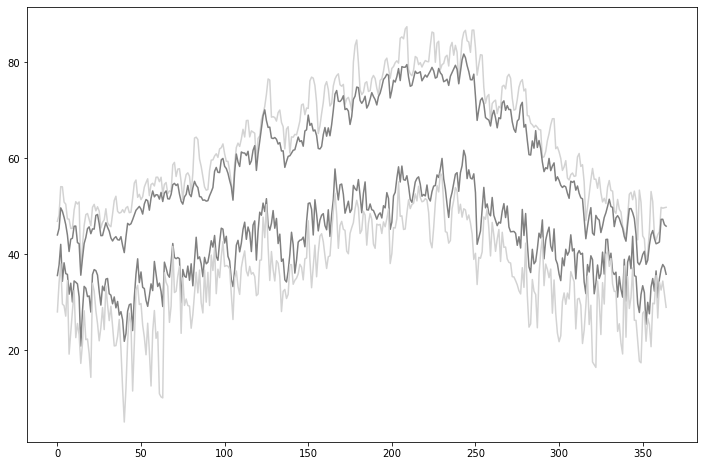

In [11]:
fig, ax = plt.subplots()

fig.set_size_inches(12, 8)


x = ds_record.index

pmax = ds_record['Peak_Maximum']
ax.plot(x, pmax, color='lightgray')

amax = ds_record['Avg_Maximum']
ax.plot(x, amax, color='gray')

amin = ds_record['Avg_Minimum']
ax.plot(x, amin, color='gray')

pmin = ds_record['Peak_Minimum']
ax.plot(x, pmin, color='lightgray')

plt.show()